# Memory and Query repharsing

To provide a smooth conversational experience, it is necessary remember key information  
To do so, several strategies are followed, the main ones:
* Maintain a diciontary of extracted key data, like main concepts, and so on
* Rephrase incoming message with proxy chat history so it can be synthetized a new query version



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import List, TypedDict
from dotenv import load_dotenv

from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_qdrant import QdrantVectorStore
from langchain_core.prompts import ChatPromptTemplate

from src import utils, conf

c:\Users\manua\Documents\repos\dslabs\dslab-rag-e2e\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [3]:
conf_settings = conf.load(file="settings.yaml")
conf_infra = conf.load(file="infra.yaml")    

LLM_WORKHORSE = conf_settings.llm_workhorse
LLM_FLAGSHIP = conf_settings.llm_flagship
EMBEDDINGS = conf_settings.embeddings
VDB_URL = conf_infra.vdb_url
INDEX_NAME = conf_settings.vdb_index


# Environment Variables

In [4]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Clients

In [5]:
llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model=LLM_WORKHORSE,
    )
try:
    _ = llm.invoke("tell me a joke about devops")
except Exception as err:
    print(err)
    
embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model=EMBEDDINGS)
try:
    _ = embeddings.embed_query("healthcheck")

except Exception as err:
    print(err)



vector_store = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name=INDEX_NAME,
    url=VDB_URL,
    api_key=QDRANT_API_KEY,
)
try:
    _ = vector_store.asimilarity_search("healthcheck")
except Exception as err:
    print(err)


In [6]:
llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model=LLM_WORKHORSE,
    )



# ChatGPT under the hood

In [41]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser

chain = llm | StrOutputParser()

chain.invoke(
        [
        HumanMessage(content="How won the Physics Nobel price in 2024?"),
        AIMessage(content="John J. Hopfield and Geoffrey Hinton won the Nobel Prize in Physics in 2024 for their groundbreaking work on artificial neural networks."),
        HumanMessage(content="Why is the second one mentioned famous?"),
    ]
)

'Geoffrey Hinton is famous for his pioneering contributions to the field of artificial intelligence, particularly in developing deep learning and artificial neural networks. He played a key role in advancing machine learning techniques that enable computers to recognize patterns, understand speech, and process images more effectively. His work has had a profound impact on technologies such as voice recognition, image classification, and autonomous systems, making him one of the leading figures in AI research.'

# Context Example

In [7]:
docs = [
    Document(
        page_content="John J. Hopfield and Geoffrey Hinton received the Nobel Prize in Physics in 2024 for their groundbreaking work on artificial neural networks, a foundation of modern AI. Hopfield developed an associative memory model in the 1980s that allows networks to store and reconstruct patterns. Building on this, Hinton developed the Boltzmann machine, which uses statistical physics principles to recognize and classify data. These pioneering contributions are essential for today's machine learning technologies, enhancing applications from medical imaging to material science.",
        metadata={"source": "wikipedia"}
    ),
    Document(
        page_content="In Chemistry, David Baker, Demis Hassabis, and John Jumper were honored win Nobel Prize in 2024 for their breakthroughs in protein structure prediction. Baker’s work in computational protein design enables the creation of novel proteins, while Hassabis and Jumper, known for their work with DeepMind's AlphaFold, developed an AI that accurately predicts protein structures—a long-standing challenge in biology. This advancement could lead to transformative applications in drug development and synthetic biology.",
        metadata={"source": "wikipedia"}
    ),
]


In [9]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = [
            HumanMessage(content="How won the Physics Nobel price in 2024?"),
            AIMessage(content="John J. Hopfield and Geoffrey Hinton won the Nobel Prize in Physics in 2024 for their groundbreaking work on artificial neural networks."),
        ]

incoming_question = "Why is the second one mentioned famous?"

# Memory Rephrase

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


rephrase_template = """Given the following conversation and a follow up question, \
    rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""

prompt_rephrase = ChatPromptTemplate.from_template(rephrase_template)
chain_rephrase = prompt_rephrase | llm | StrOutputParser()

resp = chain_rephrase.invoke(
    {
        "question": incoming_question,
        "chat_history": chat_history
    }
)

resp

'Why is Geoffrey Hinton famous?'

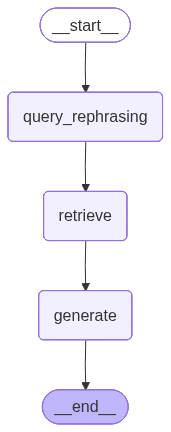

In [11]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph


# Built-in in memory manager
# Can be subsituted by a remote DB, like PG
# from langgraph.checkpoint.postgres import PostgresSaver
memory = MemorySaver()

# MessagesState is a built-in State specific for managed conversation
# https://langchain-ai.github.io/langgraph/how-tos/graph-api/#messagesstate
class State(MessagesState):
    # messages already there and with an reducing strategy
    q_star: str   # rephrased query
    context: List[Document]
    answer: str

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])


def query_rephrasing(state: State):
    relevant_hist = state["messages"][-5:]
    print(f"Relevant history size: {len(relevant_hist)}")
    question = relevant_hist.pop(-1)
    print(f"{len(relevant_hist)=}")  # always -1

    resp = chain_rephrase.invoke(
        {"question": question,
         "chat_history":relevant_hist }
    )

    return {"q_star": resp}

def retrieve(state: State):
    return {"context": docs}

prompt_template = """Answer the question based only on the following context:
```
{context}
```
Question: {question}
"""
prompt_rag = ChatPromptTemplate.from_template(prompt_template)
chain_rag = prompt_rag | llm


def generate(state: State):
    question = state['q_star']
    docs_content = format_docs(state["context"])

    resp = chain_rag.invoke({
        "context": docs_content,
        "question": question
        }
    )

    return {"messages": [resp], "answer": resp }


# Define the (single) node in the graph
workflow.add_node("query_rephrasing", query_rephrasing)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_edge(START, "query_rephrasing")
workflow.add_edge("query_rephrasing", "retrieve")
workflow.add_edge("retrieve", "generate")



app = workflow.compile(checkpointer=memory)
app

In [12]:
config = {"configurable": {"thread_id": "abc123"}}


query = "How won the Physics Nobel price in 2024?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

Relevant history size: 1
len(relevant_hist)=0
================================== Ai Message ==================================

John J. Hopfield and Geoffrey Hinton won the Nobel Prize in Physics in 2024.


In [13]:
query = "Why is the second one mentioned famous?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

Relevant history size: 3
len(relevant_hist)=2
================================== Ai Message ==================================

Geoffrey Hinton is famous for developing the Boltzmann machine, which uses statistical physics principles to recognize and classify data. His pioneering work on artificial neural networks is a foundation of modern AI and has significantly contributed to today's machine learning technologies.


In [14]:
for msg in output['messages']:
    msg.pretty_print()

================================ Human Message =================================

How won the Physics Nobel price in 2024?
================================== Ai Message ==================================

John J. Hopfield and Geoffrey Hinton won the Nobel Prize in Physics in 2024.
================================ Human Message =================================

Why is the second one mentioned famous?
================================== Ai Message ==================================

Geoffrey Hinton is famous for developing the Boltzmann machine, which uses statistical physics principles to recognize and classify data. His pioneering work on artificial neural networks is a foundation of modern AI and has significantly contributed to today's machine learning technologies.
